# SKATER

## Spatial 'K'luster Analysis by Tree Edge Removal

Authors: [Xin Feng](https://github.com/xf37), [James Gaboardi](https://github.com/jGaboardi)

----------------------

*SKATER* ([Assunção et al. 2006](doi.org/10.1080/13658810600665111)) is a constrained spatial regionalization algorithm based on spanning tree pruning. The number of edges is pre-specified to be cut in a continuous tree to group spatial units into contiguous regions.  

The first step of *SKATER* is to create a connectivity graph that captures the neighbourhood relationship between the spatial objects. The cost of each edge in the graph is inversely proportional to the similarity between the regions it joins. The neighbourhood is structured by a [minimum spanning tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree) (MST), which is a connected tree with no circuits. The next step is to partition the MST by successive removal of edges that link dissimilar regions. The final result is the division of the spatial objects into connected regions that have maximum internal homogeneity.

* **RM Assunção, MC Neves, G Câmara, and C da Costa Freitas**. *Efficient regionalization techniques for socio-economic geographical units using minimum spanning trees*. International Journal of Geographical Information Science, 20(7):797–811, 2006. doi: [10.1080/13658810600665111](doi.org/10.1080/13658810600665111).

--------------

This Tutorial .............

1. An explanation of the *SKATER* algorithm
2. .....
3. .....




See also [Dmitry Shkolnik's tutorial](https://www.dshkol.com/post/spatially-constrained-clustering-and-regionalization/) of the *SKATER* algorithm implemented in Roger Bivand's `R` package, [`spdep`](https://r-spatial.github.io/spdep/index.html).

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-12-25T15:27:09.090970-05:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import numpy
import shapely
from sklearn.metrics import pairwise as skm
import spopt

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

geopandas: 0.12.2
libpysal : 4.7.0
shapely  : 2.0.0
json     : 2.0.9
sklearn  : 1.2.0
spopt    : 0.4.1+200.g336f235.dirty
numpy    : 1.23.5



-----------------

## #. supporting data... Airbnb Spots Clustering in Chicago

To illustrate `Skater` we utilize data on Airbnb spots in Chicago, which can be downloaded from [libpysal.examples](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html).

We can first explore the data by plotting the number of Airbnb spots in each community in the sample, using a quintile classification:

In [3]:
libpysal.examples.load_example("AirBnB")

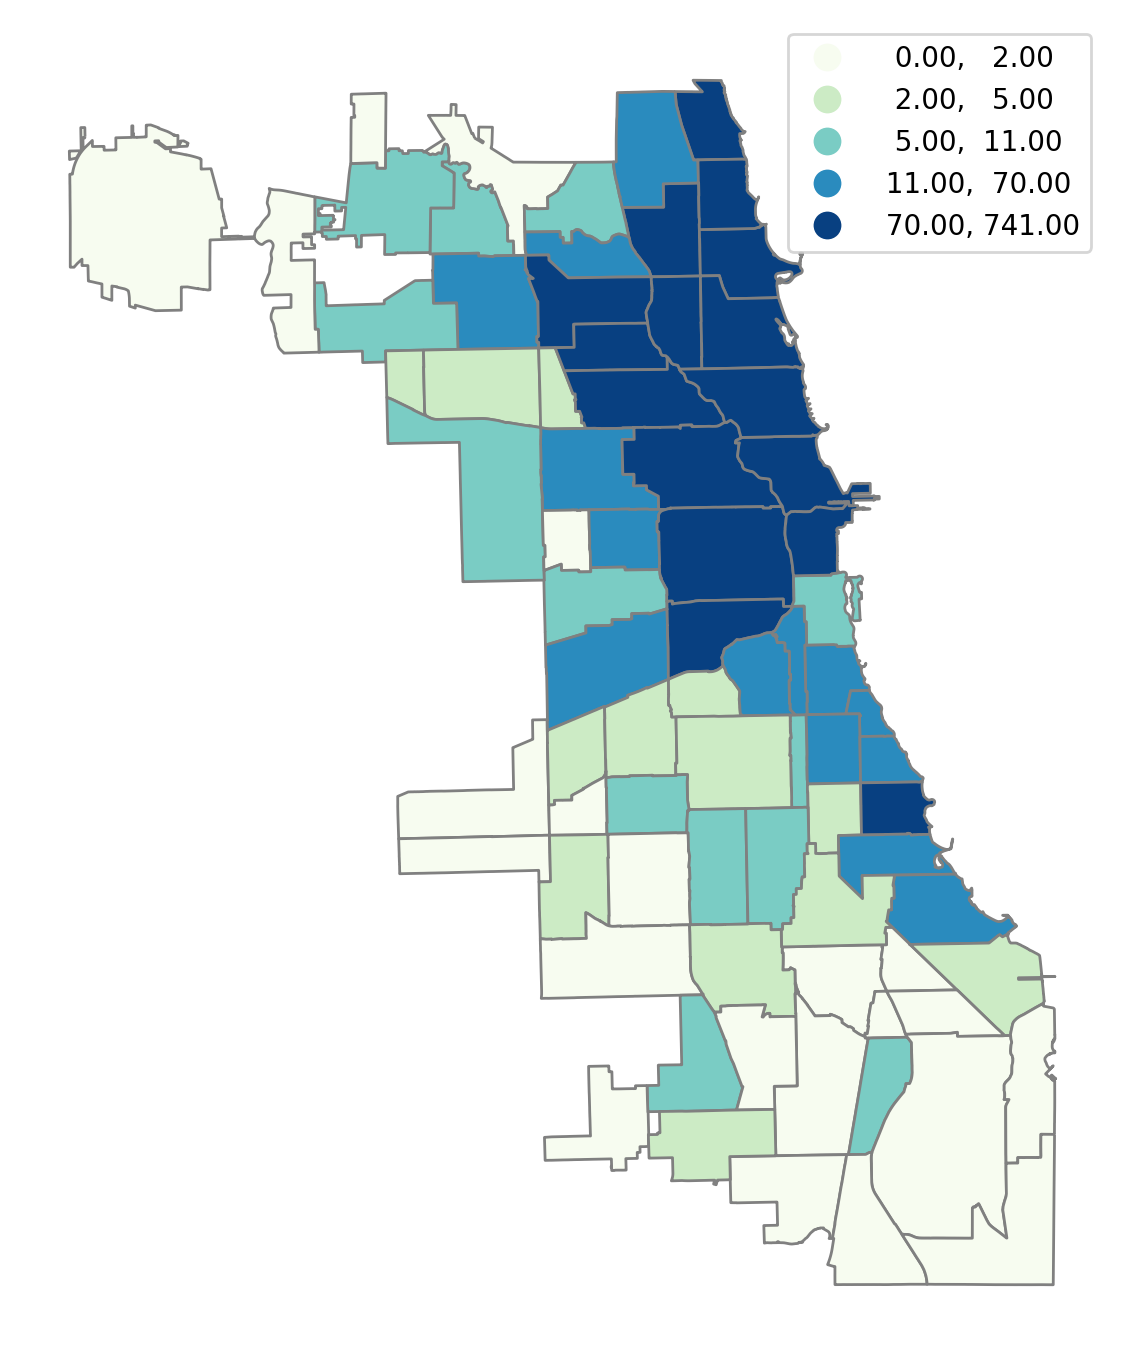

In [4]:
pth = libpysal.examples.get_path("airbnb_Chicago 2015.shp")
chicago = geopandas.read_file(pth)
chicago.plot(
    figsize=(7, 14),
    column="num_spots",
    scheme="Quantiles",
    cmap="GnBu",
    edgecolor="grey",
    legend=True
).axis("off");

## #. understanding parameters ... 

With Skater, we can cluster these 77 communities into 5 regions such that each region consists of at least 5 communities. The homogeneity of the number of Airbnb spots per county within the regions is maximized.

We first define the variable that will be used to measure regional homogeneity, which is the number of Airbnb spots in this case.

In [5]:
attrs_name = ["num_spots"]

Next, we specify a number of other parameters that will serve as input to the `skater` model, including the spatial weights (to describe the relationship between the spatial objects), the number of regions to include in the solution, the minimal threshold of spatial objects in each region, etc.

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) describes the spatial connectivity of the spatial objects:

In [6]:
w = libpysal.weights.Queen.from_dataframe(chicago)

The number of contiguous regions that we would like to group spatial units into:

In [7]:
n_clusters = 5

The minimum number of spatial objects in each region：

In [8]:
floor = -numpy.inf

 `trace` is a bool denoting whether to store intermediate labelings as the tree gets pruned.

In [9]:
trace = False

The `islands` keyword argument describes what is to be done with islands. It can be set to either `'ignore'`, which will treat each island as its own region when solving for `n_clusters` regions, or `'increase'`, which will consider each island as its own region and add to `n_clusters` regions.

In [10]:
islands = "increase"

We can also specify some keywords as input to the spanning forest algorithm, including:

* **dissimilarity**
  * A callable distance metric, with the default as [`sklearn.metrics.pairwise.manhattan_distances`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html).
* **affinity**
  * A callable affinity metric between 0 and 1, which is inverted to provide a dissimilarity metric. No metric is provided as a default (`None`).
* **reduction**
  * The reduction applied over all clusters to provide the map score, with the default as [`numpy.sum()`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html).
* **center**
  * The method for computing the center of each region in attribute space with the default as [`numpy.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html).
* **verbose**
  * A flag for how much output to provide to the user in terms of print statements and progress bars. Set to `1` for minimal output and `2` for full output. The default is `False`, which provides no output.

See ``spopt.region.skater.SpanningForest`` for documentation.

In [11]:
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=2
)

## #. Regionalization


The model can then be instantiated and solved:

In [12]:
model = spopt.region.Skater(
    chicago,
    w,
    attrs_name,
    n_clusters=n_clusters,
    floor=floor,
    trace=trace,
    islands=islands,
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 1624.56it/s]


making cut deletion(in_node=45, out_node=67, score=3445.5)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 1270.40it/s]


making cut deletion(in_node=15, out_node=13, score=2574.6813186813188)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1126.78it/s]


making cut deletion(in_node=57, out_node=32, score=1760.9493087557603)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 1047.64it/s]

making cut deletion(in_node=22, out_node=67, score=1555.4493087557603)...


In [13]:
chicago["skater_new"] = model.labels_
chicago["number"] = 1
chicago[["skater_new", "number"]].groupby(by="skater_new").count()

,number
skater_new,
0,62
1,7
2,1
3,4
4,3


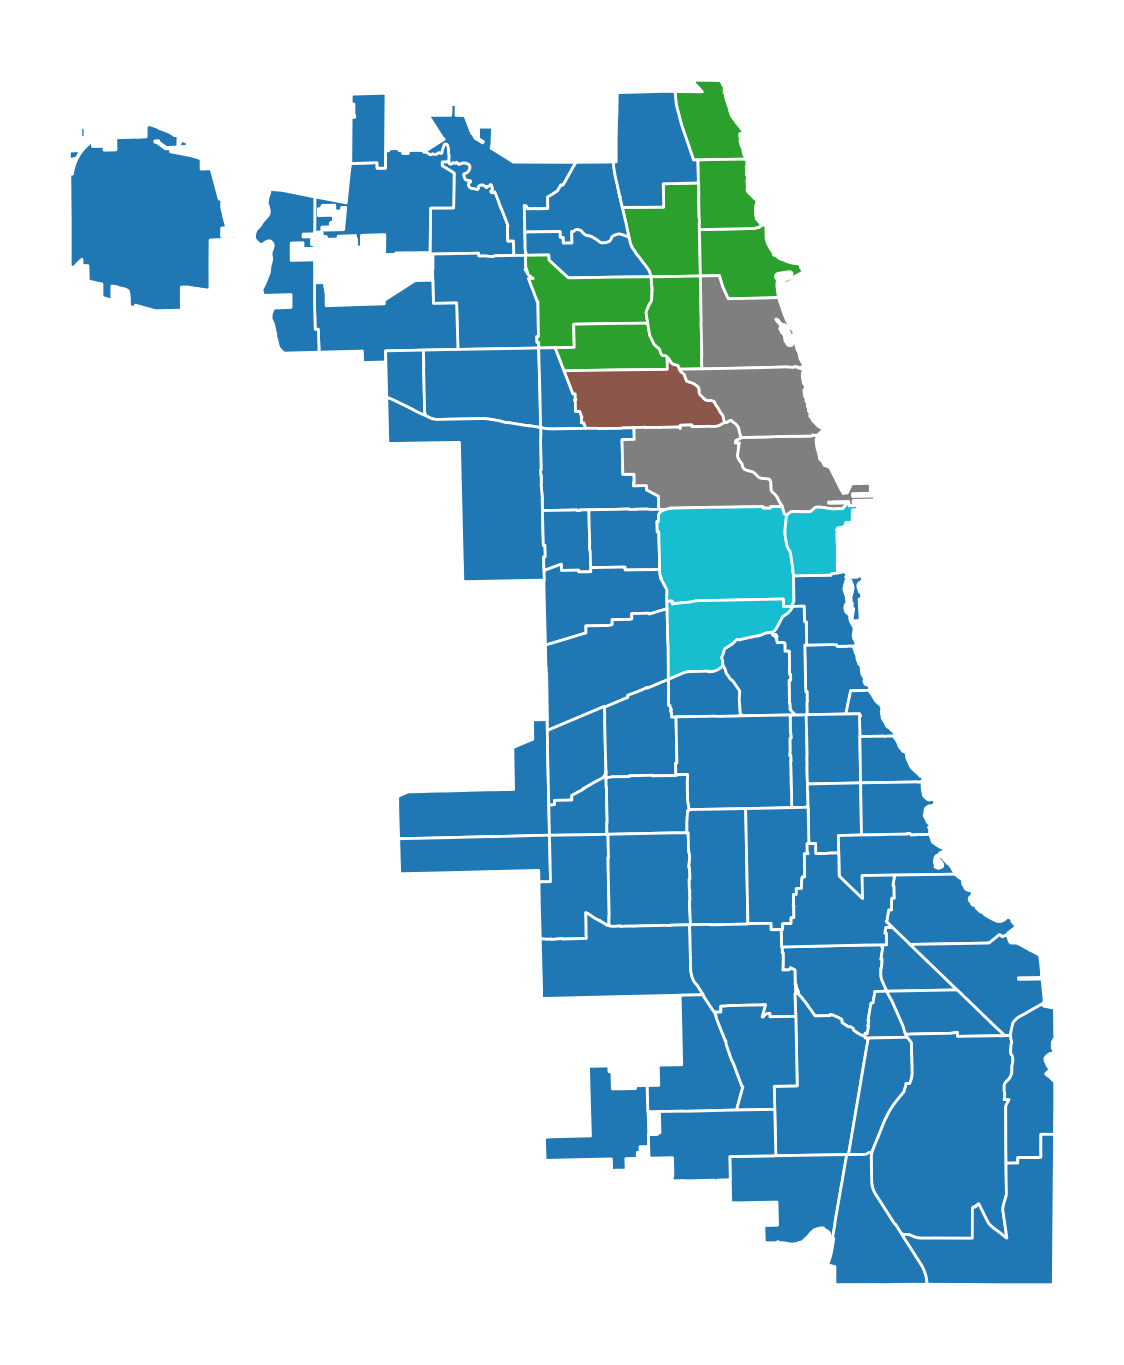

In [14]:
chicago.plot(
    figsize=(7, 14), column="skater_new", categorical=True, edgecolor="w"
).axis("off");

The model solution results in five regions, two of which have five communities, one with six, one with seven, and one with fifty-four communities. 

### demo with mosiac of technics... (maybe 4 parameter sets?)

In [15]:
#chicago, w, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds

In [16]:
# n_clusters, floor, trace, islands,
# 1. --- 5, 5, False, "increase",
# 1. --- 10, 10, True, "ignore",
# 1. --- 5, 5, False, "increase",
# 1. --- 5, 5, False, "increase",

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), deletion(in_node=nan, out_node=nan, score=inf))


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 2443.75it/s]


making cut deletion(in_node=15, out_node=45, score=3931.727272727273)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 2670.85it/s]


making cut deletion(in_node=34, out_node=2, score=3521.927272727273)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1998.59it/s]


making cut deletion(in_node=55, out_node=31, score=3457.596103896104)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 2269.34it/s]


making cut deletion(in_node=74, out_node=16, score=3448.8961038961043)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 2928.98it/s]


making cut deletion(in_node=39, out_node=69, score=3443.1757575757574)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3288.56it/s]
/Users/the-gaboardi/spopt/spopt/region/skater.py:490: OptimizeWarning: MSF contains no valid moves after finding 6 subtrees.Decrease the size of your quorum to find the remaining 4 subtrees.
  model.fit(


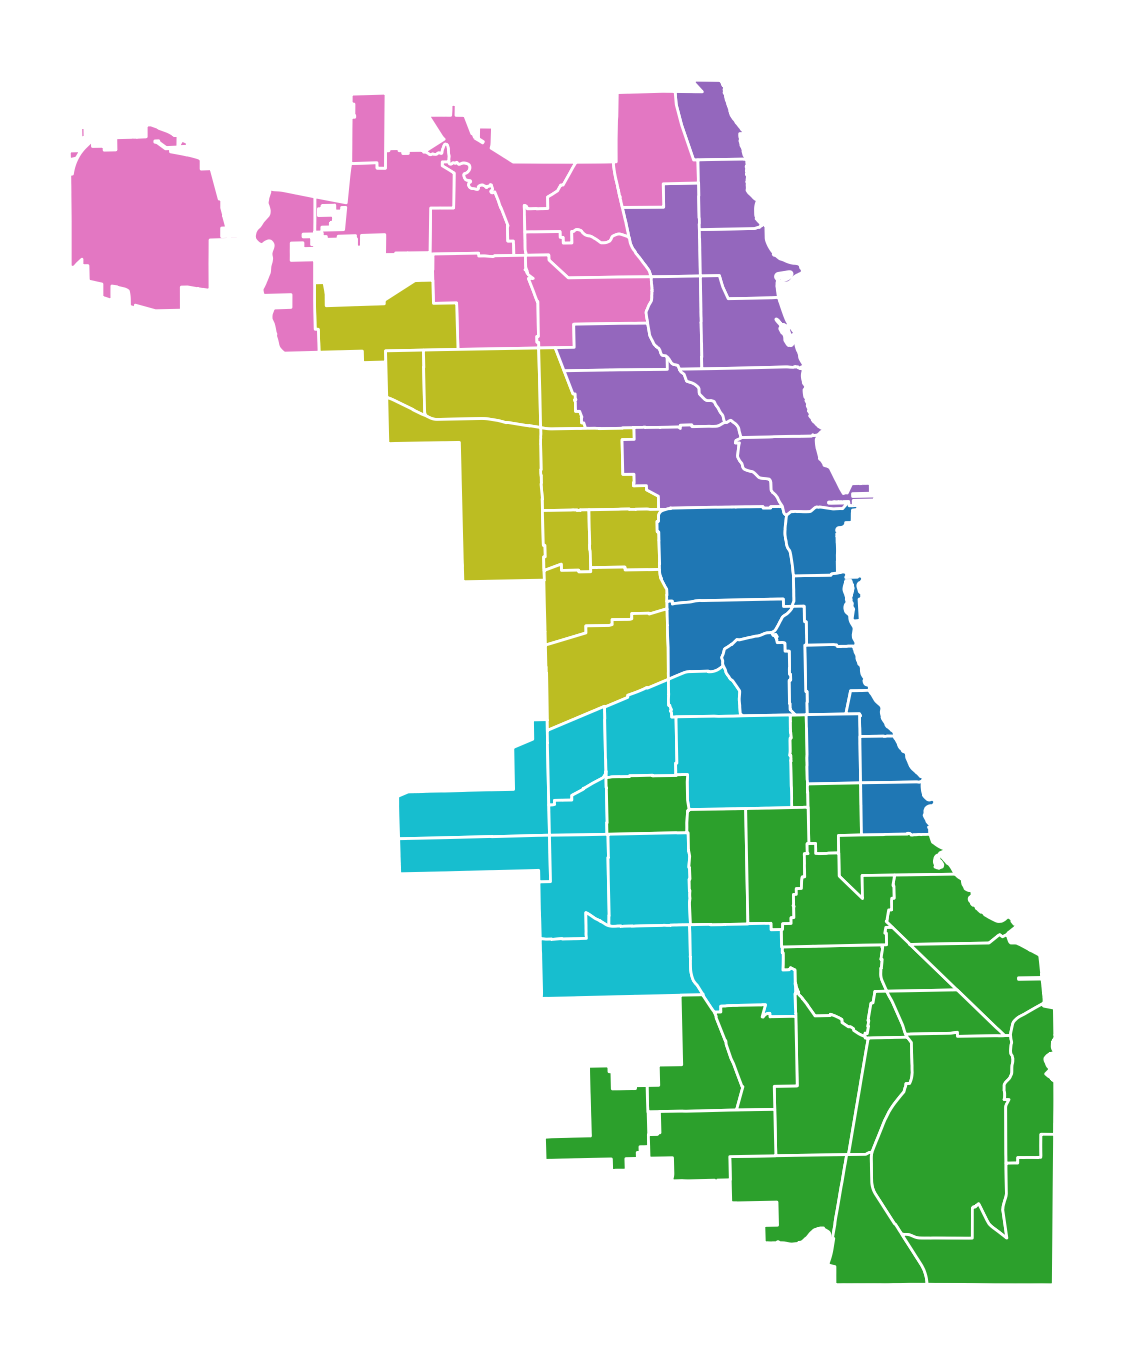

In [17]:
model = spopt.region.Skater(
    chicago,
    w,
    attrs_name,
    n_clusters=10,
    floor=10,
    trace=True,
    islands="ignore",
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()
chicago["skater_new"] = model.labels_
chicago["number"] = 1
chicago[["skater_new", "number"]].groupby(by="skater_new").count()
chicago.plot(
    figsize=(7, 14), column="skater_new", categorical=True, edgecolor="w"
).axis("off");

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 2147.42it/s]


making cut deletion(in_node=45, out_node=67, score=3445.5)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 2008.79it/s]


making cut deletion(in_node=15, out_node=13, score=2574.6813186813188)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1301.99it/s]


making cut deletion(in_node=57, out_node=32, score=1760.9493087557603)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 1426.39it/s]


making cut deletion(in_node=34, out_node=2, score=1581.920634920635)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1598.37it/s]


making cut deletion(in_node=75, out_node=5, score=1478.2777777777778)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1417.42it/s]


making cut deletion(in_node=10, out_node=35, score=1429.2843137254902)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1437.47it/s]


making cut deletion(in_node=47, out_node=41, score=1406.0)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 1432.99it/s]


making cut deletion(in_node=55, out_node=31, score=1377.8125)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1289.81it/s]


making cut deletion(in_node=29, out_node=25, score=1318.9791666666665)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1186.60it/s]


making cut deletion(in_node=6, out_node=2, score=1297.8095238095239)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 1438.63it/s]


making cut deletion(in_node=54, out_node=59, score=1294.9133333333334)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1452.20it/s]


making cut deletion(in_node=73, out_node=44, score=1292.8333333333333)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1407.80it/s]


making cut deletion(in_node=39, out_node=44, score=1288.0833333333333)...


finding cut...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 1397.33it/s]


making cut deletion(in_node=35, out_node=11, score=1286.1944444444446)...


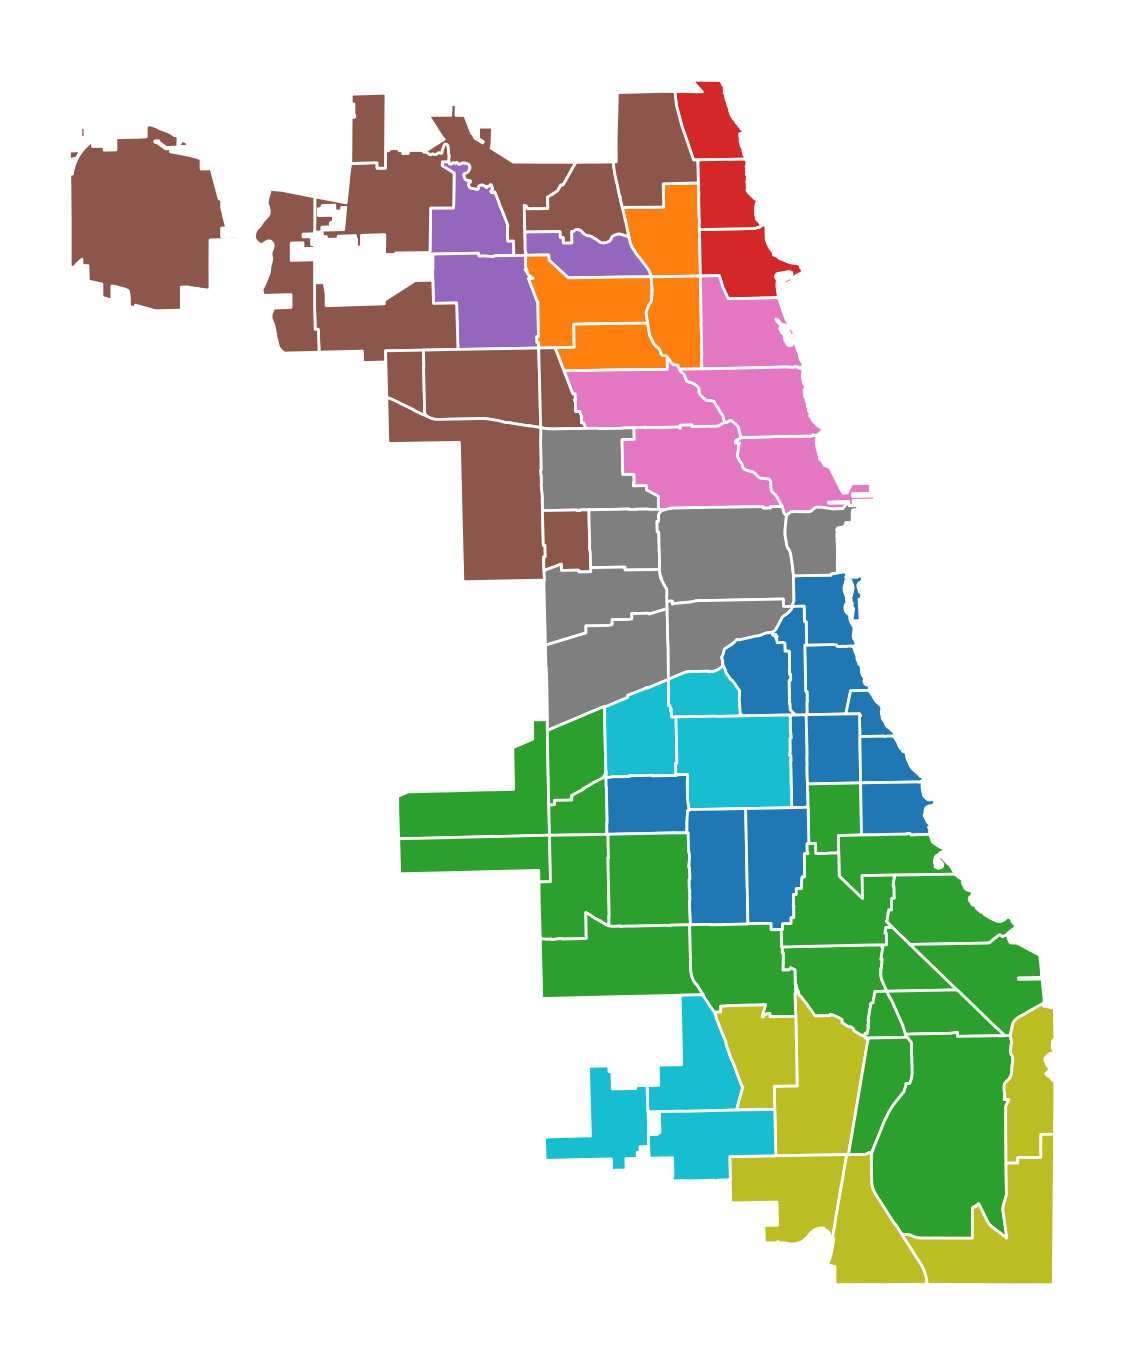

In [18]:
model = spopt.region.Skater(
    chicago,
    w,
    attrs_name,
    n_clusters=15,
    floor=3,
    trace=False,
    islands="increase",
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()
chicago["skater_new"] = model.labels_
chicago["number"] = 1
chicago[["skater_new", "number"]].groupby(by="skater_new").count()
chicago.plot(
    figsize=(7, 14), column="skater_new", categorical=True, edgecolor="w"
).axis("off");

In [30]:
#metric(chicago[attrs_name].values)

TypeError: rbf_kernel() takes from 1 to 3 positional arguments but 77 were given

In [31]:
#metric([chicago[attrs_name].values, chicago[attrs_name].values])

/var/folders/71/bk36jbtj26n_v5fhw9tnzzl00000gn/T/ipykernel_7696/1311503118.py:1: RuntimeWarning: divide by zero encountered in log
  metric = lambda xy: -numpy.log(skm.rbf_kernel(*xy))


array([[ -0., 324.,  inf, ...,  inf,  inf,  inf],
       [324.,  -0., 196., ..., 324.,  inf, 361.],
       [ inf, 196.,  -0., ...,  16.,  inf,  25.],
       ...,
       [ inf, 324.,  16., ...,  -0.,  inf,   1.],
       [ inf,  inf,  inf, ...,  inf,  -0.,  inf],
       [ inf, 361.,  25., ...,   1.,  inf,  -0.]])

In [32]:
#metric([chicago[attrs_name].values, None])

/var/folders/71/bk36jbtj26n_v5fhw9tnzzl00000gn/T/ipykernel_7696/1311503118.py:1: RuntimeWarning: divide by zero encountered in log
  metric = lambda xy: -numpy.log(skm.rbf_kernel(*xy))


array([[ -0., 324.,  inf, ...,  inf,  inf,  inf],
       [324.,  -0., 196., ..., 324.,  inf, 361.],
       [ inf, 196.,  -0., ...,  16.,  inf,  25.],
       ...,
       [ inf, 324.,  16., ...,  -0.,  inf,   1.],
       [ inf,  inf,  inf, ...,  inf,  -0.,  inf],
       [ inf, 361.,  25., ...,   1.,  inf,  -0.]])

In [24]:
-numpy.log(skm.manhattan_distances(chicago[attrs_name].values, None))

/var/folders/71/bk36jbtj26n_v5fhw9tnzzl00000gn/T/ipykernel_15103/777270109.py:1: RuntimeWarning: divide by zero encountered in log
  -numpy.log(skm.manhattan_distances(chicago[attrs_name].values, None))


array([[        inf, -2.89037176, -3.4657359 , ..., -3.58351894,
        -4.88280192, -3.61091791],
       [-2.89037176,         inf, -2.63905733, ..., -2.89037176,
        -5.01063529, -2.94443898],
       [-3.4657359 , -2.63905733,         inf, ..., -1.38629436,
        -5.09986643, -1.60943791],
       ...,
       [-3.58351894, -2.89037176, -1.38629436, ...,         inf,
        -5.12396398, -0.        ],
       [-4.88280192, -5.01063529, -5.09986643, ..., -5.12396398,
                inf, -5.12989871],
       [-3.61091791, -2.94443898, -1.60943791, ..., -0.        ,
        -5.12989871,         inf]])

In [28]:
with numpy.errstate(divide='ignore'):
    -numpy.log(skm.manhattan_distances(chicago[attrs_name].values, None))

/Users/the-gaboardi/spopt/spopt/region/skater.py:52: RuntimeWarning: divide by zero encountered in log
  metric = lambda x, y: -np.log(affinity(x, y))
/Users/the-gaboardi/spopt/spopt/region/skater.py:490: OptimizeWarning: MSF contains no valid moves after finding 5 subtrees.Decrease the size of your quorum to find the remaining 1 subtrees.
  model.fit(


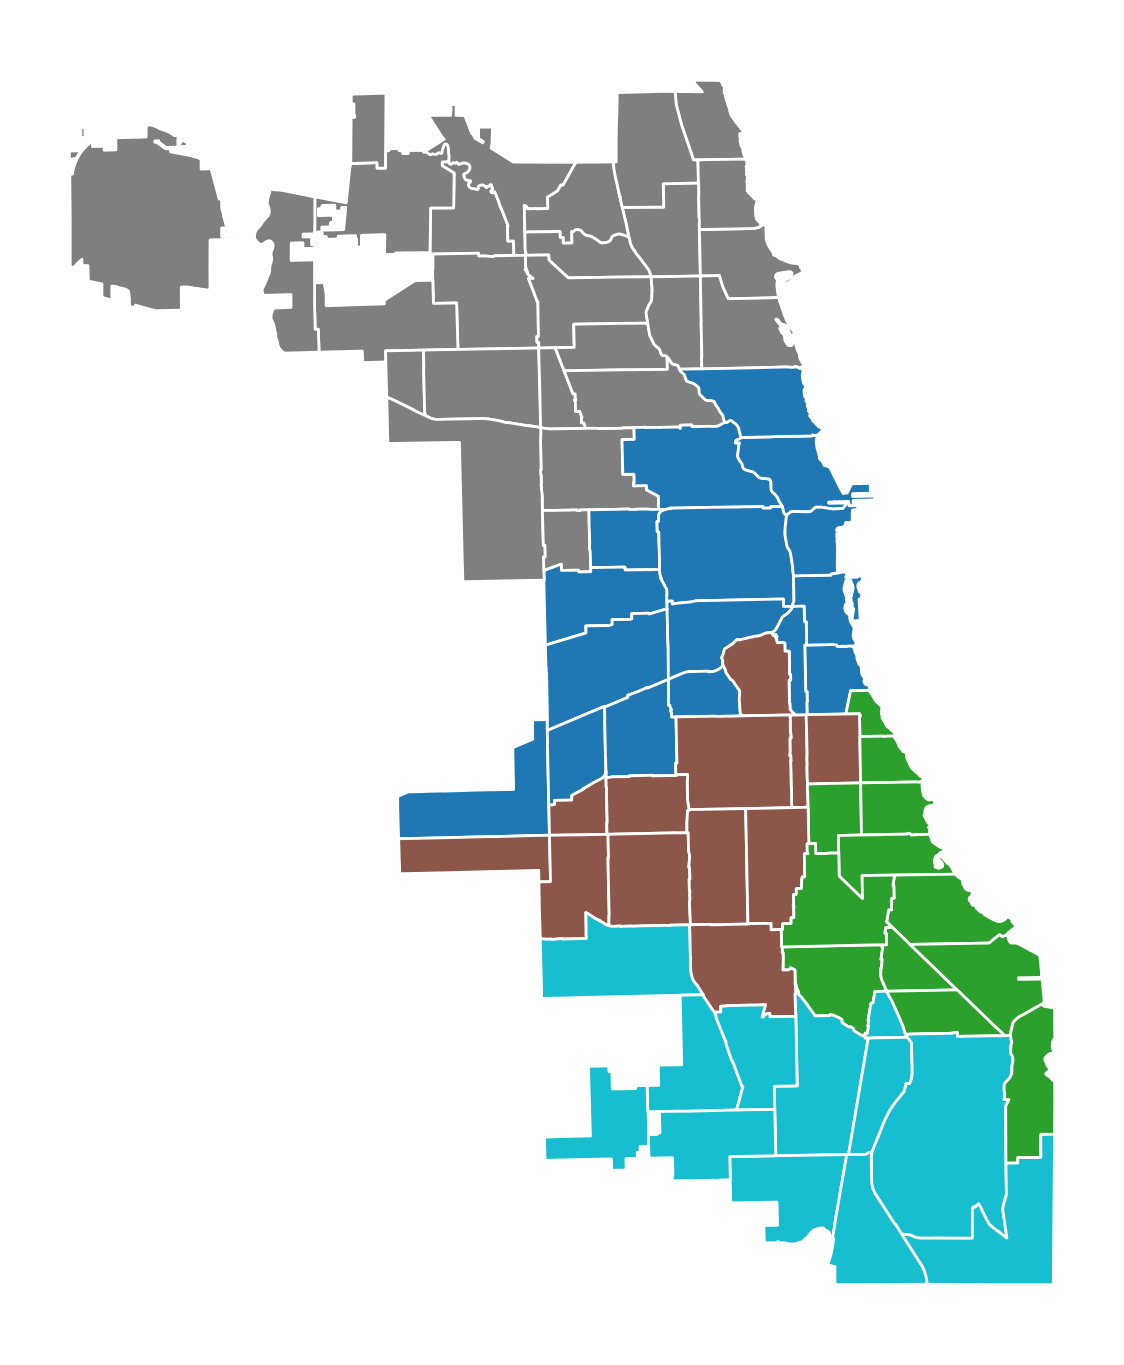

In [21]:
spanning_forest_kwds = dict(
    #dissimilarity=skm.euclidean_distances,
    affinity=skm.euclidean_distances,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=False
)
model = spopt.region.Skater(
    chicago,
    w,
    attrs_name,
    n_clusters=6,
    floor=10,
    trace=True,
    islands="ignore",
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()
chicago["skater_new"] = model.labels_
chicago["number"] = 1
chicago[["skater_new", "number"]].groupby(by="skater_new").count()
chicago.plot(
    figsize=(7, 14), column="skater_new", categorical=True, edgecolor="w"
).axis("off");

In [ ]:
attrs_name = [
    "response_r",
    "accept_r",
    "num_spots"
]

In [55]:
chicago.loc[0]

community                                               DOUGLAS
shape_area                                        46004621.1581
shape_len                                         31027.0545098
AREAID                                                       35
response_r                                            98.771429
accept_r                                              94.514286
rev_rating                                            87.777778
price_pp                                              78.157895
room_type                                              1.789474
num_spots                                                    38
poverty                                                    29.6
crowded                                                     1.8
dependency                                                 30.7
without_hs                                                 14.3
unemployed                                                 18.2
income_pc                               

In [61]:
for i in attrs_name:
    chicago[i] = chicago[i].fillna(0)

In [62]:
chicago[chicago["response_r"].isna()]

,community,shape_area,shape_len,AREAID,response_r,accept_r,rev_rating,price_pp,room_type,num_spots,...,without_hs,unemployed,income_pc,harship_in,num_crimes,num_theft,population,geometry,skater_new,number


In [51]:
chicago[["skater_new", "number"]].groupby(by="skater_new").count()

,number
skater_new,
0,5
1,54
2,7
3,5
4,6


In [38]:
print(dir(skm))

['ArgKmin', 'DataConversionWarning', 'KERNEL_PARAMS', 'PAIRED_DISTANCES', 'PAIRWISE_BOOLEAN_FUNCTIONS', 'PAIRWISE_DISTANCE_FUNCTIONS', 'PAIRWISE_KERNEL_FUNCTIONS', 'Parallel', '_NAN_METRICS', '_VALID_METRICS', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_argmin_min_reduce', '_argmin_reduce', '_check_chunk_size', '_chi2_kernel_fast', '_dist_wrapper', '_euclidean_distances', '_euclidean_distances_upcast', '_get_mask', '_num_samples', '_pairwise_callable', '_parallel_pairwise', '_precompute_metric_params', '_return_float_dtype', '_sparse_manhattan', 'additive_chi2_kernel', 'check_array', 'check_non_negative', 'check_paired_arrays', 'check_pairwise_arrays', 'chi2_kernel', 'config_context', 'cosine_distances', 'cosine_similarity', 'csr_matrix', 'delayed', 'distance', 'distance_metrics', 'effective_n_jobs', 'euclidean_distances', 'gen_batches', 'gen_even_slices', 'get_chunk_n_rows', 'haversine_distances', 'is_scalar_nan', 'isspar

In [ ]:
rows, cols = 2, 3
f, axs = plt.subplots(rows, cols, figsize=(9, 7.5))
for i in range(rows):
    for j in range(cols):
        label, title = labels[i][j], titles[i][j]
        _ax = axs[i, j]
        if i == j and i == 0:
            kws = {"scheme": "quantiles", "cmap": "Blues", "ec": "grey"}
            gdf.plot(column=label, ax=_ax, **kws)
        else:
            gdf.plot(column=label, ax=_ax, cmap="tab20")
        _ax.set_title(title)
        _ax.set_axis_off()
        _ax.set_aspect("equal")
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()